In [1]:
from pythtb import TBModel, Lattice, WFArray, Mesh
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def set_model(delta, ta, tb):
    lat_vecs = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
    orb_vecs = [[0, 0, 0], [1 / 2, 1 / 2, 1 / 2]]

    model = TBModel(Lattice(lat_vecs, orb_vecs, periodic_dirs=[0, 1, 2]))

    model.set_onsite([-delta, delta])
    for lvec in ([-1, 0, 0], [0, 0, -1], [-1, -1, 0], [0, -1, -1]):
        model.set_hop(ta, 0, 1, lvec)
    for lvec in ([0, 0, 0], [0, -1, 0], [-1, -1, -1], [-1, 0, -1]):
        model.set_hop(tb, 0, 1, lvec)

    return model

In [3]:
delta = 1.0  # site energy shift
ta = 0.4  # six weaker hoppings
tb = 0.7  # two stronger hoppings
bulk_model = set_model(delta, ta, tb)

print(bulk_model)

----------------------------------------
       Tight-binding model report       
----------------------------------------
r-space dimension           = 3
k-space dimension           = 3
periodic directions         = [0, 1, 2]
spinful                     = False
number of spin components   = 1
number of electronic states = 2
number of orbitals          = 2

Lattice vectors (Cartesian):
  # 0 ===> [ 1.000,  0.000,  0.000]
  # 1 ===> [ 0.000,  1.000,  0.000]
  # 2 ===> [ 0.000,  0.000,  1.000]
Volume of unit cell (Cartesian) = 1.000 [A^d]

Reciprocal lattice vectors (Cartesian):
  # 0 ===> [ 6.283,  0.000,  0.000]
  # 1 ===> [ 0.000,  6.283,  0.000]
  # 2 ===> [ 0.000,  0.000,  6.283]
Volume of reciprocal unit cell = 248.050 [A^-d]

Orbital vectors (Cartesian):
  # 0 ===> [ 0.000,  0.000,  0.000]
  # 1 ===> [ 0.500,  0.500,  0.500]

Orbital vectors (fractional):
  # 0 ===> [ 0.000,  0.000,  0.000]
  # 1 ===> [ 0.500,  0.500,  0.500]
----------------------------------------
Site energies:

In [4]:
bulk_model.visualize_3d()

In [5]:
# make slab model
num_layers = 9  # number of layers
slab_model = bulk_model.cut_piece(num_layers, 2, glue_edges=False)

# remove top orbital so top and bottom have the same termination
slab_model.remove_orb(2 * num_layers - 1)
slab_model.info(short=True)

----------------------------------------
       Tight-binding model report       
----------------------------------------
r-space dimension           = 3
k-space dimension           = 2
periodic directions         = [0, 1]
spinful                     = False
number of spin components   = 1
number of electronic states = 17
number of orbitals          = 17

Lattice vectors (Cartesian):
  # 0 ===> [ 1.000,  0.000,  0.000]
  # 1 ===> [ 0.000,  1.000,  0.000]
  # 2 ===> [ 0.000,  0.000,  1.000]
Volume of unit cell (Cartesian) = 1.000 [A^d]

Reciprocal lattice vectors (Cartesian):
  # 0 ===> [ 6.283,  0.000,  0.000]
  # 1 ===> [ 0.000,  6.283,  0.000]
Volume of reciprocal unit cell = 39.478 [A^-d]

Orbital vectors (Cartesian):
  # 0 ===> [ 0.000,  0.000,  0.000]
  # 1 ===> [ 0.500,  0.500,  0.500]
  # 2 ===> [ 0.000,  0.000,  1.000]
  # 3 ===> [ 0.500,  0.500,  1.500]
  # 4 ===> [ 0.000,  0.000,  2.000]
  # 5 ===> [ 0.500,  0.500,  2.500]
  # 6 ===> [ 0.000,  0.000,  3.000]
  # 7 ===> [ 0.5

In [6]:
site_colors = ["red" if i % 2 == 0 else "blue" for i in range(slab_model.norb)]
slab_model.visualize_3d(site_colors=site_colors)

In [7]:
# solve on grid to check insulating
nk = 10
k_1d = np.linspace(0, 1, nk, endpoint=False)
kpts = []
for kx in k_1d:
    for ky in k_1d:
        kpts.append([kx, ky])

evals = slab_model.solve_ham(kpts)

# delta > 0, so there are num_layers valence and num_layers - 1 conduction bands
en_valence = evals[:, :num_layers]
en_conduction = evals[:, num_layers + 1 :]

print(f"VB min, max = {np.min(en_valence):6.3f} , {np.max(en_valence):6.3f}")
print(f"CB min, max = {np.min(en_conduction):6.3f} , {np.max(en_conduction):6.3f}")

VB min, max = -4.447 , -1.000
CB min, max =  1.000 ,  4.447


In [8]:
nk = 9
mesh = Mesh(dim_k=2, axis_types=["k", "k"])
mesh.build_grid(shape=(nk, nk))
print(mesh)

Mesh Summary
Type: grid
Dimensionality: 2 k-dim(s) + 0 λ-dim(s)
Number of mesh points: 81
Full shape: (9, 9, 2)
k-axes: [Axis(type=k, name=k_0, size=9), Axis(type=k, name=k_1, size=9)]
λ-axes: []
Is a torus in k-space (all k-axes wind BZ): yes
Loops: (axis 0, comp 0, winds_bz=yes, closed=no), (axis 1, comp 1, winds_bz=yes, closed=no)


In [9]:
bloch_arr = WFArray(slab_model.lattice, mesh)
bloch_arr.solve_model(slab_model)

In [10]:
# initalize wf_array to hold HWFs, and Numpy array for HWFCs
hwf_arr = WFArray(slab_model.lattice, mesh, nstates=num_layers)
hwfc = np.zeros([nk, nk, num_layers])

# loop over k points and fill arrays with HW centers and vectors
for ix in range(nk):
    for iy in range(nk):
        (val, vec) = bloch_arr.position_hwf(
            mesh_idx=[ix, iy],
            state_idx=list(range(num_layers)),
            pos_dir=2,
            hwf_evec=True,
            basis="orbital",
        )
        hwfc[ix, iy] = val
        hwf_arr[ix, iy] = vec

# compute and print mean and standard deviation of Wannier centers by layer
print("\nLocations of hybrid Wannier centers along z:\n")
print("  Layer      " + num_layers * "  %2d    " % tuple(range(num_layers)))
print("  Mean   " + num_layers * "%8.4f" % tuple(np.mean(hwfc, axis=(0, 1))))
print("  Std Dev" + num_layers * "%8.4f" % tuple(np.std(hwfc, axis=(0, 1))))


Locations of hybrid Wannier centers along z:

  Layer         0       1       2       3       4       5       6       7       8    
  Mean     0.0582  1.0097  2.0024  3.0006  4.0000  4.9994  5.9976  6.9903  7.9418
  Std Dev  0.0410  0.0114  0.0035  0.0010  0.0000  0.0010  0.0035  0.0114  0.0410


In [11]:
# compute and print layer contributions to polarization along x, then y
px = np.zeros((num_layers, nk))
py = np.zeros((num_layers, nk))
for n in range(num_layers):
    px[n, :] = hwf_arr.berry_phase(axis_idx=0, state_idx=[n]) / (2 * np.pi)
    py[n, :] = hwf_arr.berry_phase(axis_idx=1, state_idx=[n]) / (2 * np.pi)

print("\nBerry phases along x (rows correspond to k_y points):\n")
print("  Layer      " + num_layers * "  %2d    " % tuple(range(num_layers)))
for k in range(nk):
    print("         " + num_layers * "%8.4f" % tuple(px[:, k]))
# when averaging, don't count last k-point
px_mean = np.mean(px[:, :-1], axis=1)
py_mean = np.mean(py[:, :-1], axis=1)
print("\n  Avg P_x" + num_layers * "%8.4f" % tuple(px_mean))


Berry phases along x (rows correspond to k_y points):

  Layer         0       1       2       3       4       5       6       7       8    
           0.0607  0.0090  0.0022  0.0006 -0.0000 -0.0006 -0.0022 -0.0090 -0.0607
           0.0568  0.0079  0.0018  0.0005  0.0000 -0.0005 -0.0018 -0.0079 -0.0568
           0.0448  0.0048  0.0009  0.0002 -0.0000 -0.0002 -0.0009 -0.0048 -0.0448
           0.0255  0.0014  0.0001  0.0000 -0.0000 -0.0000 -0.0001 -0.0014 -0.0255
           0.0044  0.0000  0.0000  0.0000 -0.0000 -0.0000 -0.0000 -0.0000 -0.0044
           0.0044  0.0000  0.0000  0.0000  0.0000 -0.0000 -0.0000 -0.0000 -0.0044
           0.0255  0.0014  0.0001  0.0000  0.0000 -0.0000 -0.0001 -0.0014 -0.0255
           0.0448  0.0048  0.0009  0.0002 -0.0000 -0.0002 -0.0009 -0.0048 -0.0448
           0.0568  0.0079  0.0018  0.0005 -0.0000 -0.0005 -0.0018 -0.0079 -0.0568

  Avg P_x  0.0334  0.0037  0.0008  0.0002 -0.0000 -0.0002 -0.0008 -0.0037 -0.0334


In [12]:
# compute and print layer contributions to polarization along x, then y
px = np.zeros((num_layers, nk))
py = np.zeros((num_layers, nk))
for n in range(num_layers):
    px[n, :] = hwf_arr.berry_phase(axis_idx=0, state_idx=[n]) / (2 * np.pi)
    py[n, :] = hwf_arr.berry_phase(axis_idx=1, state_idx=[n]) / (2 * np.pi)

print("\nBerry phases along x (rows correspond to k_y points):\n")
print("  Layer      " + num_layers * "  %2d    " % tuple(range(num_layers)))
for k in range(nk):
    print("         " + num_layers * "%8.4f" % tuple(px[:, k]))
# when averaging, don't count last k-point
px_mean = np.mean(px[:, :-1], axis=1)
py_mean = np.mean(py[:, :-1], axis=1)
print("\n  Avg P_x" + num_layers * "%8.4f" % tuple(px_mean))


Berry phases along x (rows correspond to k_y points):

  Layer         0       1       2       3       4       5       6       7       8    
           0.0607  0.0090  0.0022  0.0006 -0.0000 -0.0006 -0.0022 -0.0090 -0.0607
           0.0568  0.0079  0.0018  0.0005  0.0000 -0.0005 -0.0018 -0.0079 -0.0568
           0.0448  0.0048  0.0009  0.0002 -0.0000 -0.0002 -0.0009 -0.0048 -0.0448
           0.0255  0.0014  0.0001  0.0000 -0.0000 -0.0000 -0.0001 -0.0014 -0.0255
           0.0044  0.0000  0.0000  0.0000 -0.0000 -0.0000 -0.0000 -0.0000 -0.0044
           0.0044  0.0000  0.0000  0.0000  0.0000 -0.0000 -0.0000 -0.0000 -0.0044
           0.0255  0.0014  0.0001  0.0000  0.0000 -0.0000 -0.0001 -0.0014 -0.0255
           0.0448  0.0048  0.0009  0.0002 -0.0000 -0.0002 -0.0009 -0.0048 -0.0448
           0.0568  0.0079  0.0018  0.0005 -0.0000 -0.0005 -0.0018 -0.0079 -0.0568

  Avg P_x  0.0334  0.0037  0.0008  0.0002 -0.0000 -0.0002 -0.0008 -0.0037 -0.0334


In [13]:
nlh = num_layers // 2
sum_top = np.sum(py_mean[:nlh])
sum_bot = np.sum(py_mean[-nlh:])
print("\n  Surface sums: Top, Bottom = %8.4f , %8.4f\n" % (sum_top, sum_bot))


  Surface sums: Top, Bottom =  -0.0000 ,  -0.0000



Text(0, 0.5, 'Contribution to $P_x$')

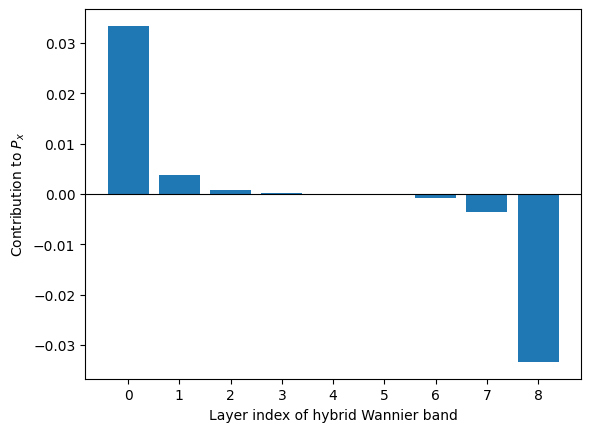

In [14]:
fig = plt.figure()
plt.bar(range(num_layers), px_mean)
plt.axhline(0.0, linewidth=0.8, color="k")
plt.xticks(range(num_layers))
plt.xlabel("Layer index of hybrid Wannier band")
plt.ylabel(r"Contribution to $P_x$")